# Predicting the Winning College Basketball Team

In [2]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline


About dataset

This dataset is about the performance of basketball teams. The cbb.csv data set includes performance data about five seasons of 354 basketball teams. It includes following fields:

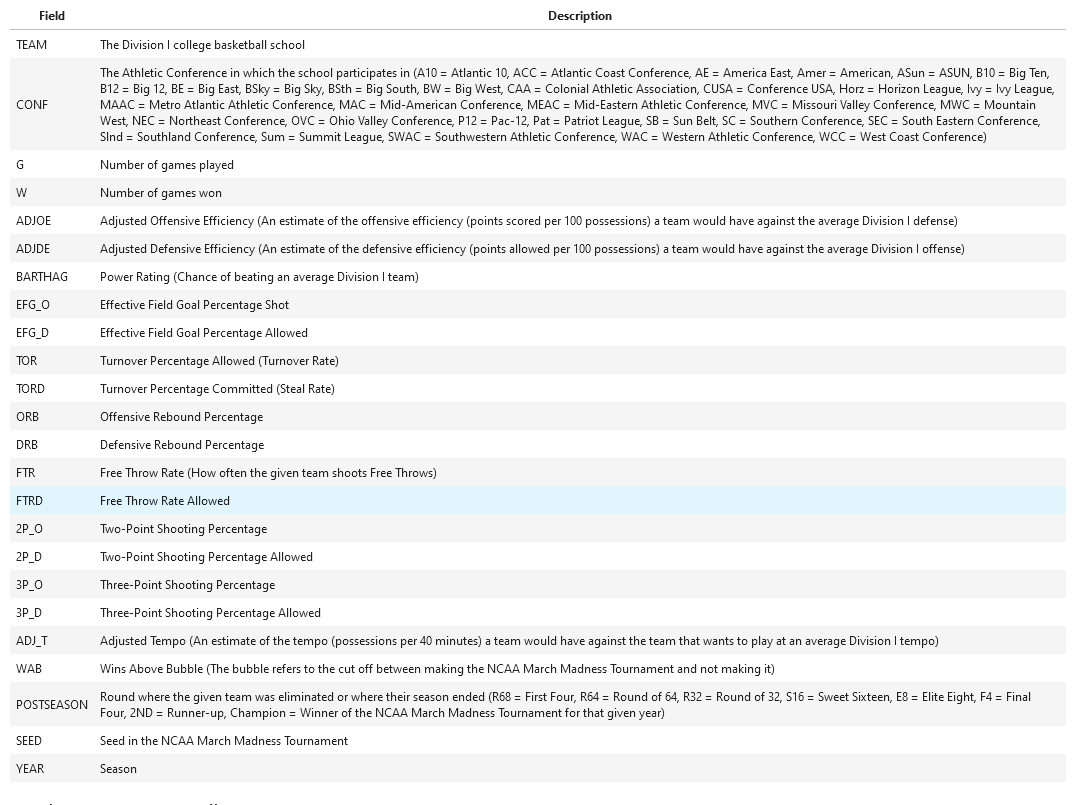


## Load Data From CSV File

Let's load the dataset [NB Need to provide link to csv file]


In [4]:
df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/cbb.csv')
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


In [5]:
df.shape

(1406, 24)


## Add Column

Next we'll add a column that will contain "true" if the wins above bubble are over 7 and "false" if not. We'll call this column Win Index or "windex" for short.


In [6]:
df['windex'] = np.where(df.WAB > 7, 'True', 'False')


## Data visualization and pre-processing

Next we'll filter the data set to the teams that made the Sweet Sixteen, the Elite Eight, and the Final Four in the post season. We'll also create a new dataframe that will hold the values with the new column.


In [7]:
df1 = df[df['POSTSEASON'].str.contains('F4|S16|E8', na=False)]
df1.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,False
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,True
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,True
5,Oregon,P12,37,30,118.4,96.2,0.9163,52.3,48.9,16.1,...,52.6,46.1,34.4,36.2,69.0,6.7,E8,1.0,2016,False
6,Syracuse,ACC,37,23,111.9,93.6,0.8857,50.0,47.3,18.1,...,47.2,48.1,36.0,30.7,65.5,-0.3,F4,10.0,2016,False


In [8]:
df1['POSTSEASON'].value_counts()

S16    32
E8     16
F4      8
Name: POSTSEASON, dtype: int64



32 teams made it into the Sweet Sixteen, 16 into the Elite Eight, and 8 made it into the Final Four over 5 seasons.

Lets plot some columns to underestand data better:


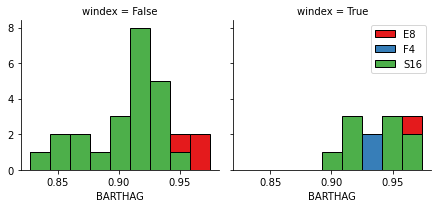

In [9]:
import seaborn as sns

bins = np.linspace(df1.BARTHAG.min(), df1.BARTHAG.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=6)
g.map(plt.hist, 'BARTHAG', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

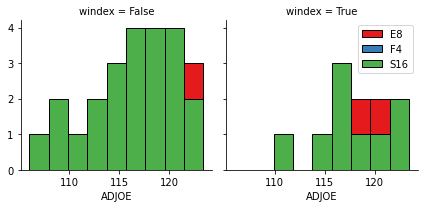

In [10]:
bins = np.linspace(df1.ADJOE.min(), df1.ADJOE.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ADJOE', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()


### Pre-processing: Feature selection/extraction
Lets look at how Adjusted Defense Efficiency plots

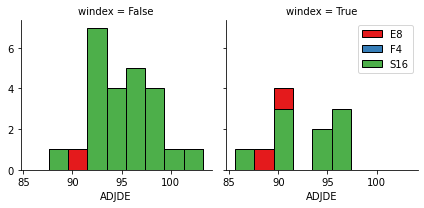

In [12]:
bins = np.linspace(df1.ADJDE.min(), df1.ADJDE.max(), 10)
g = sns.FacetGrid(df1, col="windex", hue="POSTSEASON", palette="Set1", col_wrap=2)
g.map(plt.hist, 'ADJDE', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that this data point doesn't impact the ability of a team to get into the Final Four.


### Convert Categorical features to numerical values

Lets look at the postseason:


In [13]:
df1.groupby(['windex'])['POSTSEASON'].value_counts(normalize=True)

windex  POSTSEASON
False   S16           0.605263
        E8            0.263158
        F4            0.131579
True    S16           0.500000
        E8            0.333333
        F4            0.166667
Name: POSTSEASON, dtype: float64



13% of teams with 6 or less wins above bubble make it into the final four while 17% of teams with 7 or more do.

Lets convert wins above bubble (winindex) under 7 to 0 and over 7 to 1:


In [14]:
df['windex'].replace(to_replace=['False','True'], value=[0,1],inplace=True)
df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR,windex
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016,1
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016,1
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016,0
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016,1
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016,1


### One Hot Encoding
How about seed?

In [15]:
df1.groupby(['SEED'])['POSTSEASON'].value_counts(normalize=True)

SEED  POSTSEASON
1.0   E8            0.750000
      F4            0.125000
      S16           0.125000
2.0   S16           0.444444
      E8            0.333333
      F4            0.222222
3.0   S16           0.700000
      E8            0.200000
      F4            0.100000
4.0   S16           0.875000
      E8            0.125000
5.0   S16           0.833333
      F4            0.166667
6.0   E8            1.000000
7.0   S16           0.800000
      F4            0.200000
8.0   S16           1.000000
9.0   E8            1.000000
10.0  F4            1.000000
11.0  S16           0.500000
      E8            0.250000
      F4            0.250000
12.0  S16           1.000000
Name: POSTSEASON, dtype: float64

### Feature before One Hot Encoding

In [16]:
df1[['ADJOE','ADJDE','BARTHAG','EFG_O','EFG_D']].head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D
2,118.3,103.3,0.8269,54.0,49.5
3,119.9,91.0,0.9600,54.8,48.4
4,120.9,90.4,0.9662,55.7,45.1
5,118.4,96.2,0.9163,52.3,48.9
6,111.9,93.6,0.8857,50.0,47.3


Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [17]:
Feature = df1[['ADJOE','ADJDE','BARTHAG','EFG_O','EFG_D']]
Feature = pd.concat([Feature,pd.get_dummies(df1['POSTSEASON'])], axis=1)
Feature.drop(['S16'], axis = 1,inplace=True)
Feature.head()

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,E8,F4
2,118.3,103.3,0.8269,54.0,49.5,1,0
3,119.9,91.0,0.9600,54.8,48.4,1,0
4,120.9,90.4,0.9662,55.7,45.1,1,0
5,118.4,96.2,0.9163,52.3,48.9,1,0
6,111.9,93.6,0.8857,50.0,47.3,0,1



### Feature selection

Lets defind feature sets, X:


In [18]:
X = Feature
X[0:5]

,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,E8,F4
2,118.3,103.3,0.8269,54.0,49.5,1,0
3,119.9,91.0,0.9600,54.8,48.4,1,0
4,120.9,90.4,0.9662,55.7,45.1,1,0
5,118.4,96.2,0.9163,52.3,48.9,1,0
6,111.9,93.6,0.8857,50.0,47.3,0,1


What are our lables? Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)|

In [19]:
y = df1['POSTSEASON'].values
y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)


### Normalize Data

Data Standardization give data zero mean and unit variance (technically should be done after train test split )


In [20]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.28034482,  2.74329908, -2.45717765,  0.10027963,  0.94171924,
         1.58113883, -0.40824829],
       [ 0.64758014, -0.90102957,  1.127076  ,  0.39390887,  0.38123706,
         1.58113883, -0.40824829],
       [ 0.87710222, -1.0788017 ,  1.29403598,  0.72424177, -1.30020946,
         1.58113883, -0.40824829],
       [ 0.30329703,  0.63966222, -0.04972253, -0.52368251,  0.63600169,
         1.58113883, -0.40824829],
       [-1.18859646, -0.13068368, -0.87375079, -1.36786658, -0.17924511,
        -0.63245553,  2.44948974]])


### Training and Validation

Split the data into Training and Validation data.


In [21]:
# We split the X into train and test to find the best k
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Validation set:', X_val.shape,  y_val.shape)

Train set: (44, 7) (44,)
Validation set: (12, 7) (12,)



### Classification

Now, it is your turn, use the training set to build an accurate model. Then use the validation set to report the accuracy of the model You should use the following algorithm:

    K Nearest Neighbor(KNN)
    Decision Tree
    Support Vector Machine
    Logistic Regression

K Nearest Neighbor(KNN)

**Question 1** Build a KNN model using a value of k equals three, find the accuracy on the validation data (X_val and y_val)

You can use  accuracy_score</cdoe>


In [22]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#set the k value for the model
k = 3
#training the model and predict
neigh = KNeighborsClassifier(n_neighbors=k).fit(X_train,y_train)
yhat = neigh.predict(X_val)

print(neigh,"\n")
print("Sample of five results from prediction:",yhat[0:5],'\n')
print("Validation set accuracy:",metrics.accuracy_score(y_val,yhat))

KNeighborsClassifier(n_neighbors=3) 

Sample of five results from prediction: ['F4' 'S16' 'S16' 'S16' 'S16'] 

Validation set accuracy: 1.0


**Question 2** Determine the accuracy for the first 15 values of k the on the validation data:

In [23]:
from sklearn import metrics

Ks = 15
mean_acc =  np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
Confusion_matrix = []
for n in range(1,Ks):
    neigh = KNeighborsClassifier(n_neighbors=n).fit(X_train,y_train)
    yhat = neigh.predict(X_val)
    mean_acc[n-1] = metrics.accuracy_score(y_val,yhat)
    std_acc[n-1] = np.std(yhat==y_val)/np.sqrt(yhat.shape[0])
    
mean_acc

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.91666667, 0.91666667, 0.83333333, 0.83333333,
       0.83333333, 0.83333333, 0.83333333, 0.83333333])


### Decision Tree

The following lines of code fit a DecisionTreeClassifier:


In [24]:
from sklearn.tree import DecisionTreeClassifier

In [25]:
md = 10
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))

for n in range(1,md):
    Dtree = DecisionTreeClassifier(criterion='entropy',max_depth=n).fit(X_train,y_train)
    yhat_dt = Dtree.predict(X_val)
    mean_acc[n-1]=metrics.accuracy_score(y_val,yhat_dt)
    std_acc[n-1]=np.std(yhat_dt==y_val)/np.sqrt(yhat_dt.shape[0])
    
print("The minumun value of max_depth that improves the result is:",mean_acc.argmax()+1)

The minumun value of max_depth that improves the result is: 2



### Support Vector Machine

**Question 4** Train the following linear support vector machine model and determine the accuracy on the validation data


In [26]:
from sklearn import svm

#fitting the model and predict
clf = svm.SVC(kernel='rbf')
clf.fit(X_train,y_train)
yhat_svm = clf.predict(X_val)

print("Sample of five results from prediction:",yhat_svm[:5])

Sample of five results from prediction: ['F4' 'S16' 'S16' 'S16' 'S16']


In [35]:
#Evaluation
from sklearn.metrics import f1_score, jaccard_score

print("The F1-score is:",f1_score(y_val,yhat_svm,average='weighted'),"\n")

print("The Jaccard Score is:",jaccard_score(y_val,yhat_svm,average=None))

The F1-score is: 1.0 

The Jaccard Score is: [1. 1. 1.]



### Logistic Regression

**Question 5** Train a logistic regression model and determine the accuracy of the validation data (set C=0.01)


In [36]:
from sklearn.linear_model import LogisticRegression

#fitting the model and forecast
LR = LogisticRegression(C=0.01,solver='liblinear').fit(X_train,y_train)
yhat_LR = LR.predict(X_val)
print("Sample of five results from prediction:",yhat_LR[:5])

#forecast probability of being in S16, E8, and F4
yhat_prob = LR.predict_proba(X_val)
print("Sample of five results from probability prediction:",yhat_prob[:5])

Sample of five results from prediction: ['F4' 'S16' 'S16' 'S16' 'S16']
Sample of five results from probability prediction: [[0.28989109 0.3816511  0.32845781]
 [0.31791461 0.31327122 0.36881417]
 [0.31464004 0.31447207 0.37088789]
 [0.32345584 0.31780731 0.35873686]
 [0.31498614 0.31654477 0.36846909]]


In [41]:
from sklearn.metrics import log_loss

print("The Jaccard Score is:",jaccard_score(y_val,yhat_LR,average='macro'),"\n")
print("The LogLoss is:%.2f"%log_loss(y_val, yhat_prob))

The Jaccard Score is: 1.0 

The LogLoss is:0.98


### Model Evaluation using Test set

In [42]:
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [43]:
def jaccard_index(predictions, true):
    if (len(predictions) == len(true)):
        intersect = 0;
        for x,y in zip(predictions, true):
            if (x == y):
                intersect += 1
        return intersect / (len(predictions) + len(true) - intersect)
    else:
        return -1

Calculate the F1 score and Jaccard Similarity score for each model from above. Use the Hyperparameter that performed best on the validation data.

#### Load Test set for evaluation

In [44]:
test_df = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/basketball_train.csv',error_bad_lines=False)
test_df.head()

,TEAM,CONF,G,W,ADJOE,ADJDE,BARTHAG,EFG_O,EFG_D,TOR,...,FTRD,2P_O,2P_D,3P_O,3P_D,ADJ_T,WAB,POSTSEASON,SEED,YEAR
0,North Carolina,ACC,40,33,123.3,94.9,0.9531,52.6,48.1,15.4,...,30.4,53.9,44.6,32.7,36.2,71.7,8.6,2ND,1.0,2016
1,Villanova,BE,40,35,123.1,90.9,0.9703,56.1,46.7,16.3,...,30.0,57.4,44.1,36.2,33.9,66.7,8.9,Champions,2.0,2016
2,Notre Dame,ACC,36,24,118.3,103.3,0.8269,54.0,49.5,15.3,...,26.0,52.9,46.5,37.4,36.9,65.5,2.3,E8,6.0,2016
3,Virginia,ACC,37,29,119.9,91.0,0.9600,54.8,48.4,15.1,...,33.4,52.6,46.3,40.3,34.7,61.9,8.6,E8,1.0,2016
4,Kansas,B12,37,32,120.9,90.4,0.9662,55.7,45.1,17.8,...,37.3,52.7,43.4,41.3,32.5,70.1,11.6,E8,1.0,2016


In [45]:
test_df['windex'] = np.where(test_df.WAB > 7, 'True', 'False')
test_df1 = test_df[test_df['POSTSEASON'].str.contains('F4|S16|E8', na=False)]
test_df1. head()
test_df1.groupby(['windex'])['POSTSEASON'].value_counts(normalize=True)
test_Feature = test_df1[['ADJOE','ADJDE','BARTHAG','EFG_O','EFG_D']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df1['POSTSEASON'])], axis=1)
test_Feature.drop(['S16'], axis = 1,inplace=True)
test_Feature.head()
test_X=test_Feature
test_X= preprocessing.StandardScaler().fit(test_X).transform(test_X)
test_X[0:5]

array([[ 3.37365934e-01,  2.66479976e+00, -2.46831661e+00,
         2.13703245e-01,  9.44090550e-01,  1.58113883e+00,
        -4.08248290e-01],
       [ 7.03145068e-01, -7.13778644e-01,  1.07370841e+00,
         4.82633172e-01,  4.77498943e-01,  1.58113883e+00,
        -4.08248290e-01],
       [ 9.31757027e-01, -8.78587347e-01,  1.23870131e+00,
         7.85179340e-01, -9.22275877e-01,  1.58113883e+00,
        -4.08248290e-01],
       [ 3.60227129e-01,  7.14563447e-01, -8.92254236e-02,
        -3.57772849e-01,  6.89586037e-01,  1.58113883e+00,
        -4.08248290e-01],
       [-1.12575060e+00,  3.92401673e-04, -9.03545224e-01,
        -1.13094639e+00,  1.09073363e-02, -6.32455532e-01,
         2.44948974e+00]])

In [46]:
test_y = test_df1['POSTSEASON'].values
test_y[0:5]

array(['E8', 'E8', 'E8', 'E8', 'F4'], dtype=object)

KNN

In [47]:
yhat = neigh.predict(test_X)

print("The Accuracy is:%.2f"%accuracy_score(test_y,yhat),'\n'
    "The Jaccard Score is:%.2f"%metrics.jaccard_score(test_y,yhat,average='macro'),'\n'
      "and the F1-score is:%.2f"%metrics.f1_score(test_y,yhat,average='weighted')
     )

The Accuracy is:0.80 
The Jaccard Score is:0.51 
and the F1-score is:0.74


Decision Tree

In [49]:
Dtree = DecisionTreeClassifier(criterion='entropy',max_depth=2).fit(X_train,y_train)

yhat_dt = Dtree.predict(test_X)

print("The Accuracy is:%.2f"%accuracy_score(test_y,yhat_dt),'\n',
      "The Jaccard Score is:%.2f"%metrics.jaccard_score(test_y,yhat_dt,average='macro'),'\n',
      "and the F1-score is:%.2f"%metrics.f1_score(test_y,yhat_dt,average='weighted')
     )

The Accuracy is:1.00 
 The Jaccard Score is:1.00 
 and the F1-score is:1.00


SVM

In [50]:
yhat_svm = clf.predict(test_X)

print("The Accuracy is:%.2f"%accuracy_score(test_y,yhat_svm),'\n'
    "The Jaccard Score is:%.2f"%metrics.jaccard_score(test_y,yhat_svm,average='micro'),'\n'
      "and the F1-score is:%.2f"%metrics.f1_score(test_y,yhat_svm,average='weighted')
     )

The Accuracy is:1.00 
The Jaccard Score is:1.00 
and the F1-score is:1.00




Logistic Regression


In [53]:
yhat_LR = LR.predict(test_X)

print("The Jaccard Score is:%.2f"%metrics.jaccard_score(test_y,yhat_LR,average='macro'),'\n'
      "the F1-score is:%.2f"%metrics.f1_score(test_y,yhat_LR,average='weighted'),'\n'
      "and the LogLos is:%.2f"%log_loss(y_val, yhat_prob)
     )

The Jaccard Score is:1.00 
the F1-score is:1.00 
and the LogLos is:0.98



### Report

You should be able to report the accuracy of the built model using different evaluation metrics:


In [55]:
columns = ['Algorithm','Jaccard','F1-score','LogLoss']
    
knn = ['KNN',metrics.jaccard_score(test_y,yhat,average='macro'),
       metrics.f1_score(test_y,yhat,average='weighted'),
       'NA'
      ]
DecisionTree = ['Decision Tree',metrics.jaccard_score(test_y,yhat_dt,average='macro'),
                metrics.f1_score(test_y,yhat_dt,average='weighted'),
                'NA'
               ]
SVM = ['SVM',metrics.jaccard_score(test_y,yhat_svm,average='macro'),
       metrics.f1_score(test_y,yhat_svm,average='weighted'),
       'NA'
      ]
LogisticRegression = ['LogisticRegression',metrics.jaccard_score(test_y,yhat_LR,average='macro'),
                      metrics.f1_score(test_y,yhat_LR,average='weighted'),
                      log_loss(y_val, yhat_prob)
                     ]

report = pd.DataFrame(columns=columns)

for i in range(0,len(columns)):
    results = report.columns[i]
    report[results]=[knn[i],DecisionTree[i],SVM[i],LogisticRegression[i]]
    
report = report.set_index(['Algorithm'])
    
report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.505541,0.738656,NA
Decision Tree,1.000000,1.000000,NA
SVM,1.000000,1.000000,NA
LogisticRegression,1.000000,1.000000,0.97957
